#### Average trade rate - new data
12.06.2023

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from functions_v2 import *

home_path = r'C:\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\n'
results = r'C:\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\n\results'

# Read in all use case directory paths
use_case_dir_paths = []
for root, dir, file in os.walk(top=home_path, topdown=True):
    use_case_dir_paths += [os.path.join(root, d) for d in dir if 'use_case_' in d[-10:]]
# Filter out the results subdirectory
use_case_dir_paths = [i for i in use_case_dir_paths if not 'results\\' in i]

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Retrieve specific use case directory paths to analyze/compare
use_case_0_dir_path = [i for i in use_case_dir_paths if 'use_case_0' in i][0]
use_case_4_dir_path = [i for i in use_case_dir_paths if 'use_case_4' in i][0]

# Read in all trade rates for each use case (takes 20min each!)
# avg_price_houses = avg_p_houses(use_case_0_dir_path)
# avg_price_houses.to_csv(os.path.join(results, 'use_case_0_avg_price_houses.csv'), index=True)
# avg_price_houses = avg_p_houses(use_case_4_dir_path)
# avg_price_houses.to_csv(os.path.join(results, 'use_case_4_avg_price_houses.csv'), index=True)

---

In [70]:
# Read in csv, set index to datetime and remove it as first column
def read_in_df(filepath):
    df = pd.read_csv(os.path.join(results, filepath), index_col=0).reset_index(drop=True)
    df = df.iloc[:,1:]
    return df

df0 = read_in_df('use_case_0_avg_price_houses.csv')
df4 = read_in_df('use_case_4_avg_price_houses.csv')

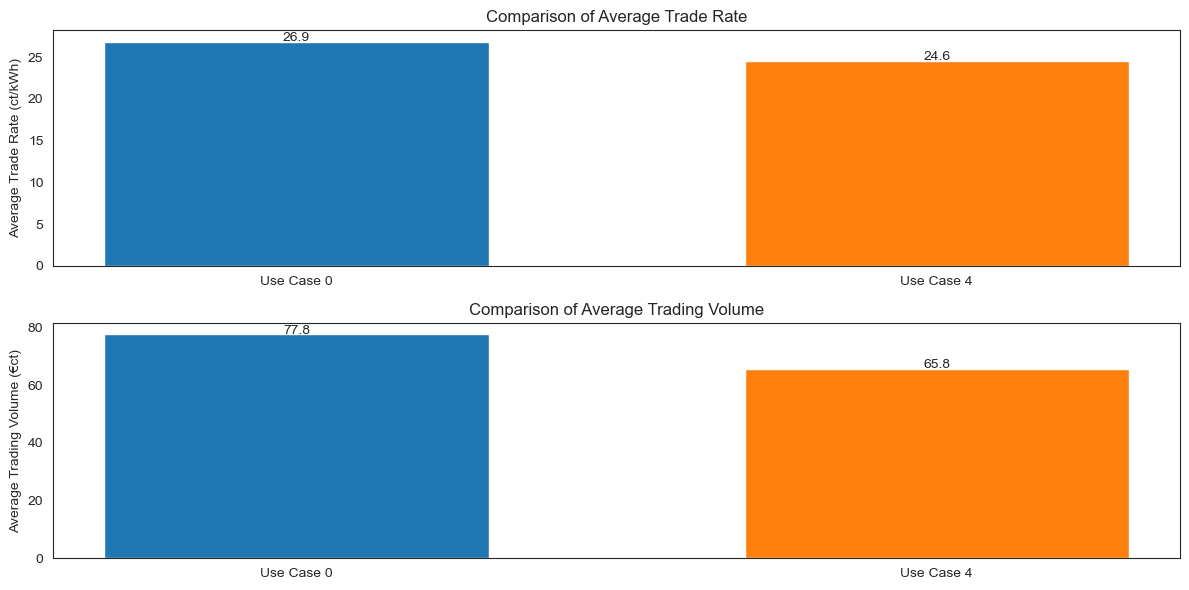

In [197]:
# Assuming you have the pandas DataFrames df0 and df4

# Calculate the overall average trade rate for each use case
avg_trade_rate_use_case_0 = df0.iloc[:, 0::2].mean().mean()
avg_trade_rate_use_case_4 = df4.iloc[:, 0::2].mean().mean()

# Calculate the overall average trading volume for each use case
avg_trading_volume_use_case_0 = df0.iloc[:, 1::2].mean().mean()
avg_trading_volume_use_case_4 = df4.iloc[:, 1::2].mean().mean()

# Set the figure size
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Get the default blue and orange colors from the current matplotlib color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
blue_color = default_colors[0]
orange_color = default_colors[1]

# Plot the average trade rate
axs[0].bar([0, 1], [avg_trade_rate_use_case_0, avg_trade_rate_use_case_4], width=0.6, color=[blue_color, orange_color])
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Use Case 0', 'Use Case 4'])
axs[0].set_ylabel('Average Trade Rate (ct/kWh)')
axs[0].set_title('Comparison of Average Trade Rate')
# Add the value labels on top of each bar in the average trade rate subplot
for i, v in enumerate([avg_trade_rate_use_case_0, avg_trade_rate_use_case_4]):
    axs[0].text(i, v + 0.1, f'{v:.1f}', ha='center')

# Plot the average trading volume
axs[1].bar([0, 1], [avg_trading_volume_use_case_0, avg_trading_volume_use_case_4], width=0.6, color=[blue_color, orange_color])
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Use Case 0', 'Use Case 4'])
axs[1].set_ylabel('Average Trading Volume (€ct)')
axs[1].set_title('Comparison of Average Trading Volume')
# Add the value labels on top of each bar in the average trading volume subplot
for i, v in enumerate([avg_trading_volume_use_case_0, avg_trading_volume_use_case_4]):
    axs[1].text(i, v + 0.1, f'{v:.1f}', ha='center')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

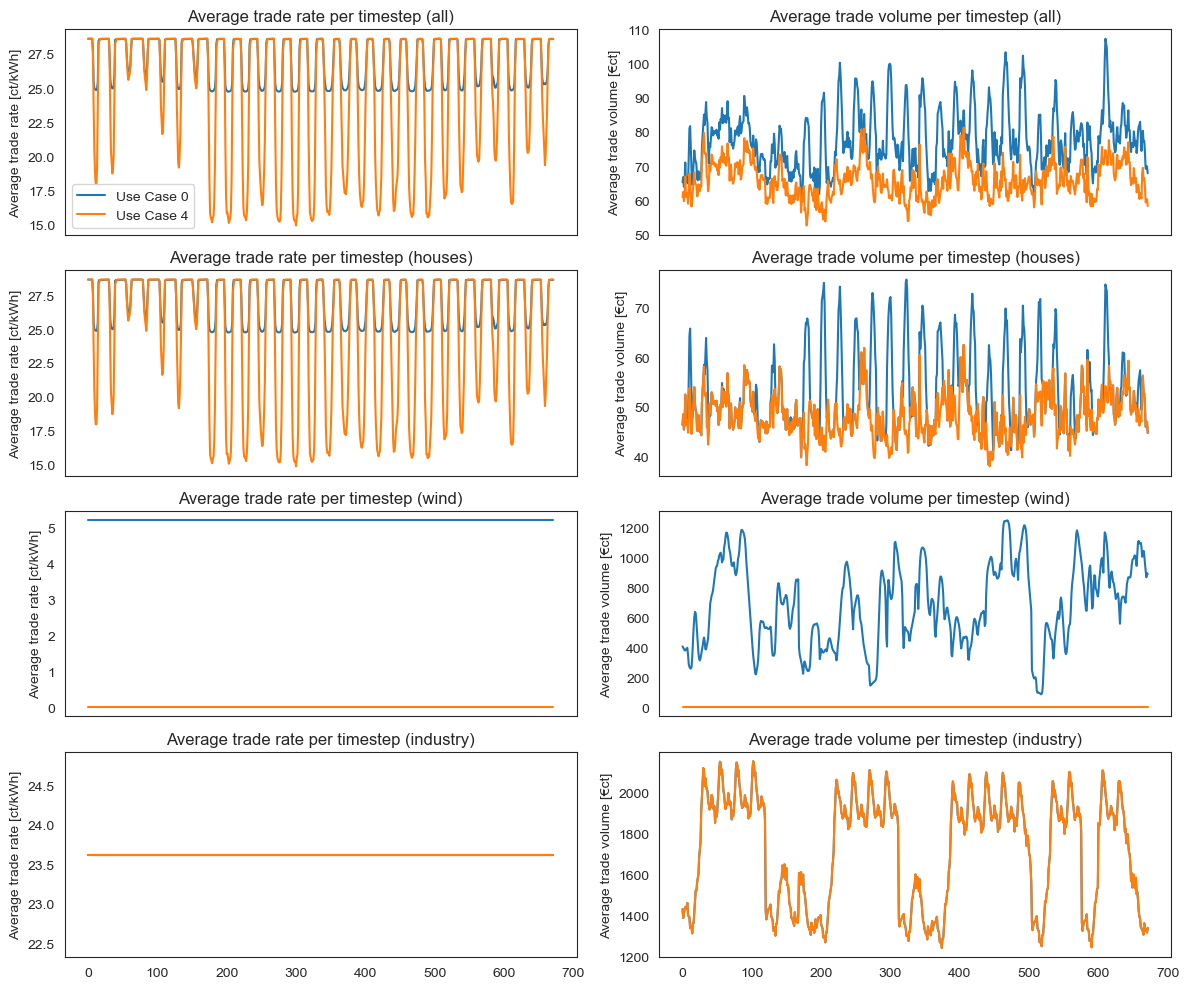

In [230]:
fig, axs = plt.subplots(4, 2, figsize=(12,10), sharex=True)

# average trade rate (all)
axs[0,0].set_title('Average trade rate per timestep (all)', fontsize=12)
axs[0,0].plot(df0[[i for i in df0.columns.tolist() if not 'wind' in i]].iloc[:,0::2].mean(axis=1), label='Use Case 0')
axs[0,0].plot(df4[[i for i in df4.columns.tolist() if not 'wind' in i]].iloc[:,0::2].mean(axis=1), label='Use Case 4')
axs[0,0].set_ylabel('Average trade rate [ct/kWh]')
axs[0,0].legend()

# average trading volume (all)
axs[0,1].set_title('Average trade volume per timestep (all)', fontsize=12)
axs[0,1].plot(df0[[i for i in df0.columns.tolist()]].iloc[:,1::2].mean(axis=1), label='Use Case 0')
axs[0,1].plot(df4[[i for i in df4.columns.tolist()]].iloc[:,1::2].mean(axis=1), label='Use Case 4')
axs[0,1].set_ylabel('Average trade volume [€ct]')

# average trade rate (houses)
axs[1,0].set_title('Average trade rate per timestep (houses)', fontsize=12)
axs[1,0].plot(df0[[i for i in df0.columns.tolist() if not 'wind' in i if not 'industry' in i]].iloc[:,0::2].mean(axis=1), label='Use Case 0')
axs[1,0].plot(df4[[i for i in df4.columns.tolist() if not 'wind' in i if not 'industry' in i]].iloc[:,0::2].mean(axis=1), label='Use Case 4')
axs[1,0].set_ylabel('Average trade rate [ct/kWh]')

# average trading volume (houses)
axs[1,1].set_title('Average trade volume per timestep (houses)', fontsize=12)
axs[1,1].plot(df0[[i for i in df0.columns.tolist() if not 'wind' in i if not 'industry' in i]].iloc[:,1::2].mean(axis=1), label='Use Case 0')
axs[1,1].plot(df4[[i for i in df4.columns.tolist() if not 'wind' in i if not 'industry' in i]].iloc[:,1::2].mean(axis=1), label='Use Case 4')
axs[1,1].set_ylabel('Average trade volume [€ct]')

# average trade rate (wind)
axs[2,0].set_title('Average trade rate per timestep (wind)', fontsize=12)
axs[2,0].plot(df0[[i for i in df0.columns.tolist() if 'wind' in i]].iloc[:,0::2].mean(axis=1), label='Use Case 0')
axs[2,0].plot(df4[[i for i in df4.columns.tolist() if 'wind' in i]].iloc[:,0::2].mean(axis=1), label='Use Case 4')
axs[2,0].set_ylabel('Average trade rate [ct/kWh]')

# average trading volume (wind)
axs[2,1].set_title('Average trade volume per timestep (wind)', fontsize=12)
axs[2,1].plot(df0[[i for i in df0.columns.tolist() if 'wind' in i]].iloc[:,1::2].mean(axis=1), label='Use Case 0')
axs[2,1].plot(df4[[i for i in df4.columns.tolist() if 'wind' in i]].iloc[:,1::2].mean(axis=1), label='Use Case 4')
axs[2,1].set_ylabel('Average trade volume [€ct]')

# average trade rate (industry)
axs[3,0].set_title('Average trade rate per timestep (industry)', fontsize=12)
axs[3,0].plot(df0[[i for i in df0.columns.tolist() if 'industry' in i]].iloc[:,0::2].mean(axis=1), label='Use Case 0')
axs[3,0].plot(df4[[i for i in df4.columns.tolist() if 'industry' in i]].iloc[:,0::2].mean(axis=1), label='Use Case 4')
axs[3,0].set_ylabel('Average trade rate [ct/kWh]')

# average trading volume (industry)
axs[3,1].set_title('Average trade volume per timestep (industry)', fontsize=12)
axs[3,1].plot(df0[[i for i in df0.columns.tolist() if 'industry' in i]].iloc[:,1::2].mean(axis=1), label='Use Case 0')
axs[3,1].plot(df4[[i for i in df4.columns.tolist() if 'industry' in i]].iloc[:,1::2].mean(axis=1), label='Use Case 4')
axs[3,1].set_ylabel('Average trade volume [€ct]')

plt.tight_layout()
plt.show()

In [142]:
def filter_df(df, word, kpi=None):
    assert kpi in ['rate', 'volume'], f'kpi ({kpi}) must be in [None, rate, volume]'
    if kpi == 'rate':
        kpi_slicer = 0
    if kpi == 'volume':
        kpi_slicer = 1
    cols = [i for i in df.columns if word in i]
    if kpi_slicer is not None:
        df = df[cols].iloc[:, kpi_slicer::2]
    else:
        df = df[cols]
    
    return df

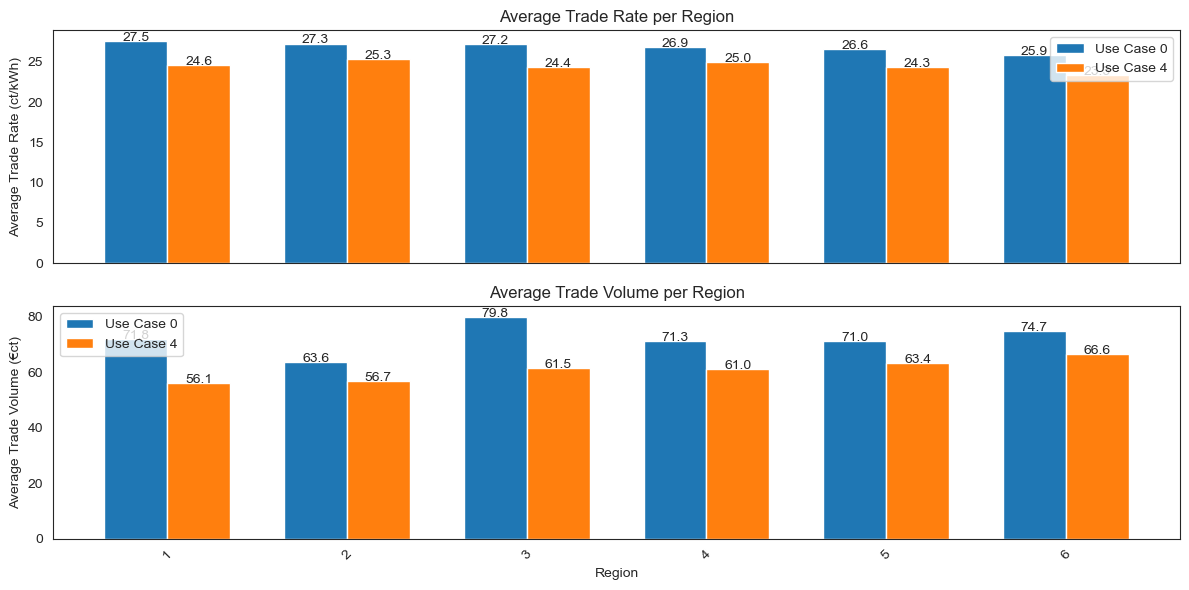

In [188]:
regions = np.sort(list(set([col.split('_')[1] for col in df0.columns[1::2]])))

# Initialize lists to store the average trade rates per region for each use case
avg_trade_rate_use_case_0 = []
avg_trade_rate_use_case_4 = []
avg_trade_volume_use_case_0 = []
avg_trade_volume_use_case_4 = []

# Loop over the regions
for region in regions:
    # Filter the average trade rate for entities belonging to the current region
    region_avg_trade_rate_use_case_0 = df0.loc[:, df0.columns.str.contains(f'_{region}_')].iloc[:, 0::2].mean().mean()
    region_avg_trade_rate_use_case_4 = df4.loc[:, df4.columns.str.contains(f'_{region}_')].iloc[:, 0::2].mean().mean()
    region_avg_trade_volume_use_case_0 = df0.loc[:, df0.columns.str.contains(f'_{region}_')].iloc[:, 1::2].mean().mean()
    region_avg_trade_volume_use_case_4 = df4.loc[:, df4.columns.str.contains(f'_{region}_')].iloc[:, 1::2].mean().mean()

    # Append the average trade rates to the corresponding lists
    avg_trade_rate_use_case_0.append(region_avg_trade_rate_use_case_0)
    avg_trade_rate_use_case_4.append(region_avg_trade_rate_use_case_4)
    avg_trade_volume_use_case_0.append(region_avg_trade_volume_use_case_0)
    avg_trade_volume_use_case_4.append(region_avg_trade_volume_use_case_4)

# Set the figure size
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
bar_positions_use_case_0 = np.arange(len(regions))
bar_positions_use_case_4 = bar_positions_use_case_0 + bar_width

# Plot the clustered bars
ax[0].bar(bar_positions_use_case_0, avg_trade_rate_use_case_0, width=bar_width, label='Use Case 0')
ax[0].bar(bar_positions_use_case_4, avg_trade_rate_use_case_4, width=bar_width, label='Use Case 4')
ax[1].bar(bar_positions_use_case_0, avg_trade_volume_use_case_0, width=bar_width, label='Use Case 0')
ax[1].bar(bar_positions_use_case_4, avg_trade_volume_use_case_4, width=bar_width, label='Use Case 4')

# Set the x-axis tick positions and labels
ax[0].set_xticks(bar_positions_use_case_0 + bar_width / 2)
ax[0].set_xticklabels(regions)
ax[1].set_xticks(bar_positions_use_case_0 + bar_width / 2)
ax[1].set_xticklabels(regions)

# Set the y-axis label
ax[0].set_ylabel('Average Trade Rate (ct/kWh)')
ax[1].set_ylabel('Average Trade Volume (€ct)')
ax[1].set_xlabel('Region')

# Set the title and add a legend
ax[0].set_title('Average Trade Rate per Region')
ax[1].set_title('Average Trade Volume per Region')
ax[0].legend()
ax[1].legend()

# Add the value labels on top of each bar
for i, v in enumerate(avg_trade_rate_use_case_0):
    ax[0].text(bar_positions_use_case_0[i], v + 0.01, f'{v:.1f}', ha='center')
for i, v in enumerate(avg_trade_rate_use_case_4):
    ax[0].text(bar_positions_use_case_4[i], v + 0.01, f'{v:.1f}', ha='center')

# Add the value labels on top of each bar
for i, v in enumerate(avg_trade_volume_use_case_0):
    ax[1].text(bar_positions_use_case_0[i], v + 0.01, f'{v:.1f}', ha='center')
for i, v in enumerate(avg_trade_volume_use_case_4):
    ax[1].text(bar_positions_use_case_4[i], v + 0.01, f'{v:.1f}', ha='center')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()